**Examples**

One Queue or Two

One server, one queue

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

In [6]:
def make_system(lam, mu):
    return System(lam=lam, mu=mu, duration=10*60)
interarrival_time = 8
service_time = 5
lam = 1 / interarrival_time
mu = 1 / service_time
system = make_system(lam, mu)

In [7]:
def update_func1(x, t, system):
    # if there's a customer in service, check if they're done
    if x > 0:
        if flip(system.mu):
            x -= 1
    # check for an arrival
    if flip(system.lam):
        x += 1
    return x
update_func1(1, 0, system)

1

In [31]:
def run_simulation(system, update_func):
    x = 0
    results = TimeSeries(name='Queue length')
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x
    return results

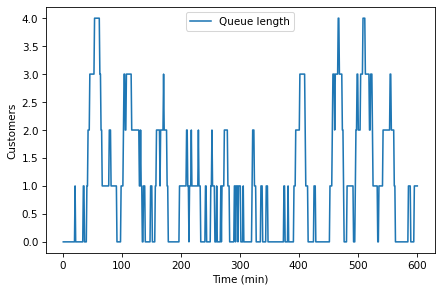

In [32]:
results = run_simulation(system, update_func1)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')

In [33]:
def compute_metrics(results, system):
    L = results.mean()
    W = L / system.lam
    return L, W
compute_metrics(results, system)

(1.0033277870216306, 8.026622296173045)

Parameter sweep

In [34]:
num_vals = 101
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
lam_array

array([0.02  , 0.0214, 0.0228, 0.0242, 0.0256, 0.027 , 0.0284, 0.0298,
       0.0312, 0.0326, 0.034 , 0.0354, 0.0368, 0.0382, 0.0396, 0.041 ,
       0.0424, 0.0438, 0.0452, 0.0466, 0.048 , 0.0494, 0.0508, 0.0522,
       0.0536, 0.055 , 0.0564, 0.0578, 0.0592, 0.0606, 0.062 , 0.0634,
       0.0648, 0.0662, 0.0676, 0.069 , 0.0704, 0.0718, 0.0732, 0.0746,
       0.076 , 0.0774, 0.0788, 0.0802, 0.0816, 0.083 , 0.0844, 0.0858,
       0.0872, 0.0886, 0.09  , 0.0914, 0.0928, 0.0942, 0.0956, 0.097 ,
       0.0984, 0.0998, 0.1012, 0.1026, 0.104 , 0.1054, 0.1068, 0.1082,
       0.1096, 0.111 , 0.1124, 0.1138, 0.1152, 0.1166, 0.118 , 0.1194,
       0.1208, 0.1222, 0.1236, 0.125 , 0.1264, 0.1278, 0.1292, 0.1306,
       0.132 , 0.1334, 0.1348, 0.1362, 0.1376, 0.139 , 0.1404, 0.1418,
       0.1432, 0.1446, 0.146 , 0.1474, 0.1488, 0.1502, 0.1516, 0.153 ,
       0.1544, 0.1558, 0.1572, 0.1586, 0.16  ])

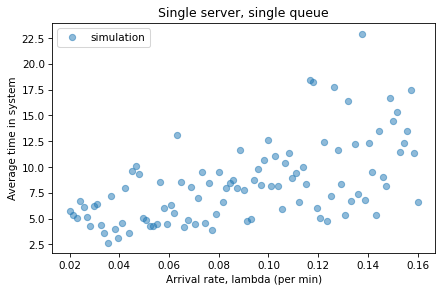

In [35]:
def sweep_lam(lam_array, mu, update_func):
    sweep = SweepSeries()
    for lam in lam_array:
        system = make_system(lam, mu)
        results = run_simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W
    return sweep
sweep = sweep_lam(lam_array, mu, update_func1)
sweep.plot(style='o', alpha=0.5, label='simulation')

decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

In [36]:
W_avg = sweep.mean()
W_avg

8.403831701092367

Analysis

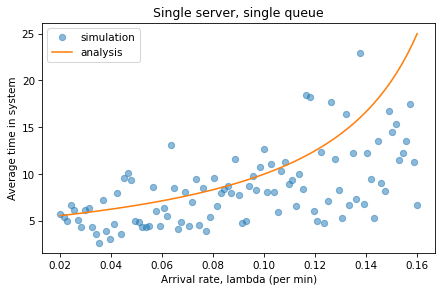

In [37]:
def plot_W(lam_array, mu):
    W_array = 1 / (mu - lam_array)
    W_series = make_series(lam_array, W_array)
    W_series.plot(style='-', label='analysis')
sweep.plot(style='o', alpha=0.5, label='simulation')
plot_W(lam_array, mu)

decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Single server, single queue')

Multiple servers

(1.0033277870216306, 8.026622296173045)

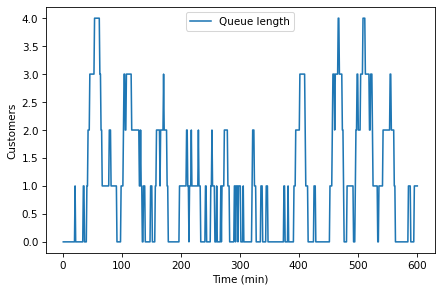

In [38]:
def update_func2(x, t, system):
    # if both servers are busy, check whether the
    # second is complete
    if x > 1 and flip(system.mu):
        x -= 1

    # check whether the first is complete
    if x > 0 and flip(system.mu):
        x -= 1

    # check for an arrival
    if flip(system.lam):
        x += 1

    return x
system = make_system(lam, mu)
run_simulation(system, update_func2)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

In [39]:
lam_array = linspace(0.1*mu, 1.6*mu, num_vals)
sweep = sweep_lam(lam_array, mu, update_func2)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  5.9490725495316 minutes


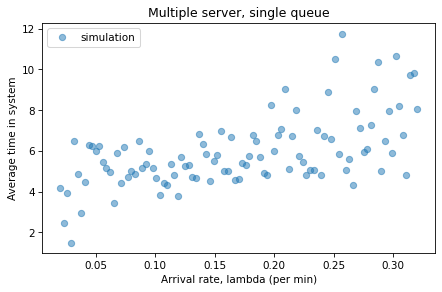

In [40]:
sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, single queue')

Multiple queues

(1.0033277870216306, 8.026622296173045)

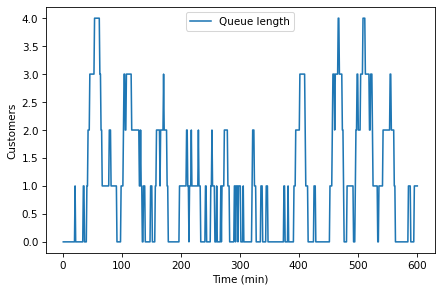

In [41]:
def update_func3(x1, x2, t, system):
    # if the first servers is busy, check it it's done
    if x1 > 0 and flip(system.mu):
        x1 -= 1

    # if the second queue is busy, check if it's done
    if x2 > 0 and flip(system.mu):
        x2 -= 1

    # check for an arrival
    if flip(system.lam):
        # join whichever queue is shorter
        if x1 < x2:
            x1 += 1
        else:
            x2 += 1

    return x1, x2
def run_simulation(system, update_func):
    x1, x2 = 0, 0
    results = TimeSeries()
    results[0] = x1 + x2

    for t in linrange(0, system.duration):
        x1, x2 = update_func(x1, x2, t, system)
        results[t+1] = x1 + x2

    return results
system = make_system(lam, mu)
run_simulation(system, update_func3)
results.plot()
decorate(xlabel='Time (min)', ylabel='Customers')
compute_metrics(results, system)

In [42]:
sweep = sweep_lam(lam_array, mu, update_func3)
W_avg = sweep.mean()
print('Average of averages = ', W_avg, 'minutes')

Average of averages =  6.356107347621984 minutes


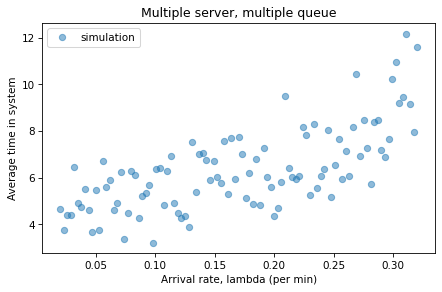

In [43]:
sweep.plot(style='o', alpha=0.5, label='simulation')
decorate(xlabel='Arrival rate, lambda (per min)',
         ylabel='Average time in system',
         title='Multiple server, multiple queue')

In [44]:
"""
With two queues, the average of averages is slightly higher, most of the time, difference is small.

The two configurations are equally good as long as both servers
are busy; the only time two lines is worse is if one queue is  empty and the other contains more than one customer.
If we allow customers to change lanes, that disadvantage can be eliminated.

In theory one line is better. In practical, the difference is small and can be mitigated. Best choice depends on
practical considerations.

Substantially better with an express line for customers with short service times.
"""

'\nWith two queues, the average of averages is slightly higher, most of the time, difference is small.\n\nThe two configurations are equally good as long as both servers \nare busy; the only time two lines is worse is if one queue is  empty and the other contains more than one customer.  \nIf we allow customers to change lanes, that disadvantage can be eliminated.\n\nIn theory one line is better. In practical, the difference is small and can be mitigated. Best choice depends on \npractical considerations.\n\nSubstantially better with an express line for customers with short service times.  \n'